In [1]:
# Setup
import os
import warnings
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter, AutoMinorLocator

import cv2
from PIL import Image
from glob import glob
import scipy.io as io
import astropy.io.fits as fits
from astropy import units as u, time as time
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.wcs import WCS
import sunpy.map
from sunpy.map import Map
from sunpy.coordinates import frames
import sunpy.visualization.colormaps as cm
from aiapy.calibrate import (
    degradation,
    register,
    update_pointing,
    correct_degradation
)
from aiapy.calibrate.util import get_correction_table 
import demregpy
from demregpy import dn2dem

cv2.destroyAllWindows()
warnings.filterwarnings('ignore')
#=================SETTINGs===========================
# How many image sets will you compare
global COMP_NUM
COMP_NUM = 2
global BOUNDARY
BOUNDARY = 40
global MANUAL_POINTs
# MANUAL_POINTs = False
MANUAL_POINTs = True

if MANUAL_POINTs == True:
    points_AIA = (np.load('/userhome/youn_j/DEM/Result/Result_vF_rev1/array_241125/20220307T0830_AIA_dataarray_Fig4.npy'))
    points_EUI = (np.load('/userhome/youn_j/DEM/Result/Result_vF_rev1/array_241125/20220307T0830_EUI_dataarray_Fig4.npy'))


#=================FUNCTIONs===========================


def restore(maps):
    _tmp_data = maps.data
    _tmp_hdr = maps.meta
    _tmp_data = np.clip(_tmp_data,-1,2)
    _tmp_data = (2**(_tmp_data*7+7))-1
    _tmp_MAP = Map(_tmp_data, _tmp_hdr)        
    return _tmp_MAP

def DEM_SET(input_folder):

    file_path = input_folder+'*fits'
    files = sorted(glob(file_path)) 
    maps = []
    
    for _tmp in files:
        fits_data = fits.open(_tmp)
        image = fits_data[0].data
        hdr = fits_data[0].header
        hdr['cunit1'] = 'arcsec' 
        hdr['cunit2'] = 'arcsec'
        hdr["crval1"] = 0
        hdr["crval2"] = 0
        hdr["euxcen"] = 512
        hdr["euycen"] = 512
        hdr["pc1_1"] = 1
        hdr["pc1_2"] = 0
        hdr["pc2_1"] = 0
        hdr["pc2_2"] = 1
        mapping = Map(image, hdr)
        maps.append(mapping)
        print(_tmp)
    # maps = sorted(maps, key=lambda x: x.wavelength)
    # maps = [aiaprep(m) for m in maps]
    maps = [restore(m) for m in maps] #메커니즘..?
    
    return maps

def setting(maps, inst):
    nx=int(maps[0].dimensions.x.value)
    ny=int(maps[0].dimensions.y.value)
    nf=6
    data=np.zeros([nx,ny,nf])
    #convert from our list to an array of data
    for j in np.arange(nf):
        data[:,:,j]=maps[j].data
    data[data < 0]=0
    serr_per=10.0 # 뭘 의미하는 걸까..?
    #errors in dn/px/s
    edata=np.zeros([nx,ny,nf])
    if inst == 'AIA':
        gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
        dn2ph=gains*[94,131,171,193,211,335]/3397.0   # 12398/3.65 ~ 3397 (Boerner et al. 2012)
        rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
        npix= 1 #1024.**2/(nx*ny)
        
        
    if inst == 'EUI':
        gains=np.array([18.3,17.6,31.025,18.3,18.3,17.6])
        dn2ph=gains*[94,131,174,193,211,335]/3397.0   # 12398/3.65 ~ 3397 (Boerner et al. 2012)
#         dn2ph[2]=gains[2]*174/1810.0 # 12398/6.85 ~ 1810 (174, https://www.sidc.be/EUI/data/latest_release_notes.html)
        dn2ph[2]=gains[2]*174/1696 # 12398/7.31 ~ 1810 (174, referenced by Frederic)
        rdnse=np.array([1.14,1.18,2.0,1.20,1.20,1.18]) #(174, https://www.sidc.be/EUI/data/latest_release_notes.html)
        npix= 1
        
    drknse=0.17
    qntnse=0.288819*np.sqrt(npix)/npix
    
    for j in np.arange(nf):
        etemp=np.sqrt(rdnse[j]**2.+drknse**2.+qntnse**2.+(dn2ph[j]*data[:,:,j] * npix)/(npix*dn2ph[j]**2))
        esys=serr_per*data[:,:,j]/100.
        edata[:,:,j]=np.sqrt(etemp**2. + esys**2.)
        
    return data, edata



#=====================================================================================================================================
def UniqueArray(x_pos,y_pos):

    array = np.array([x_pos ,y_pos])
    reshaped = np.transpose(array)
    unique_array = np.unique(array, axis=0)
    
    return unique_array

In [2]:
#DEM calculate_1 (Imaging)

date = '20220307T0830'



AIA_path = '/userhome/youn_j/DEM/DEM_testsetV240610/AIA/{}/2022-03-07T083824_171.fits'.format(date) #Plot할 이미지
AIA_path_ROI = '/userhome/youn_j/DEM/DEM_testsetV240610/AIA/{}/2022-03-07T083824_171.fits'.format(date) #ROI 찍을 이미지
EUI_path = '/userhome/youn_j/DEM/DEM_testsetV240610/EUI_Gen/{}/2022-03-07T0833_174.fits'.format(date)
image_save_path = './test/'       
ROI_NUM = 'fig4'

# COMP_NUM = 2
input_folder_AIA = '/userhome/youn_j/DEM/DEM_testsetV240610/AIA/{}/'.format(date)
input_folder_EUI = '/userhome/youn_j/DEM/DEM_testsetV240610/EUI_Gen/{}/'.format(date)



# List to store points
points = []
if MANUAL_POINTs == False:
    # Callback function for mouse events
    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
    
    AIA_fits = fits.open(AIA_path_ROI)
    AIA_image = AIA_fits[0].data
    AIA_image = (2**(AIA_image*7+7))
    
    image = AIA_image * (5/np.max(AIA_image))
    
    # Create a window and set the callback function
    cv2.namedWindow('image')
    cv2.setMouseCallback('image', click_event)
    
    # Display the image and draw the ROI
    while True:
        clone = image.copy()
        if len(points) > 1:
            cv2.polylines(clone, [np.array(points)], False, (0, 255, 0), 1)
        cv2.imshow('image', clone)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            shape_completed = True
        if key == ord('q') and len(points) > 2:
            break
    cv2.destroyAllWindows()
    
    # Create a mask
    mask = np.zeros(image.shape[:2], dtype="uint8")
    
    # Check if the number of points is sufficient to draw a polygon
    if len(points) > 2:
        cv2.fillPoly(mask, [np.array(points)], 255)
    
        # Get ROI
        ROI = cv2.bitwise_and(image, image, mask=mask)
        cv2.imshow('ROI', ROI)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("Please select at least three points to form a closed shape.")

    ROI = np.where(mask >254) 
    _p = np.array(points)
    vertex = np.append(_p,[_p[0]],axis = 0)
    print(vertex[:,:])

else:   
    
    mask = np.array(points_AIA, dtype=np.uint8)
    ROI = np.where(mask > 0)
    
    corners = cv2.goodFeaturesToTrack(mask, maxCorners=10, qualityLevel=0.01, minDistance=5)
    # 
    # 검출된 코너가 존재하는지 확인
    if corners is not None:
        corners = np.int0(corners)  # 정수형으로 변환
        for corner in corners:
            x, y = corner.ravel()
            print(f"Corner: ({x}, {y})")
            points.append((x, y))
            
    else:
        print("No corners detected.")

    _p = np.array(points)
    center = np.mean(_p, axis=0)  # (center_x, center_y)
    angles = np.arctan2(_p[:, 1] - center[1], _p[:, 0] - center[0])
    sorted_indices = np.argsort(angles)  # 반시계방향 정렬
    _p = _p[sorted_indices]

    vertex = np.append(_p,[_p[0]],axis = 0)
    print(vertex[:,:])


Corner: (703, 469)
Corner: (694, 469)
Corner: (700, 446)
Corner: (694, 464)
Corner: (702, 458)
Corner: (695, 452)
[[695 452]
 [700 446]
 [702 458]
 [703 469]
 [694 469]
 [694 464]
 [695 452]]


In [3]:
print(_p)

[[695 452]
 [700 446]
 [702 458]
 [703 469]
 [694 469]
 [694 464]]


In [4]:

#DEM calculate_2 (Imaging)
#   ============================================================================================
# Load the AIA FITS file
AIA_fits = fits.open(AIA_path)
AIA_data = AIA_fits[0].data
AIA_hdr = AIA_fits[0].header
AIA_hdr['cunit1'] = 'arcsec' 
AIA_hdr["crval1"] = 0
AIA_hdr["crval2"] = 0
AIA_hdr["pc1_1"] = 1
AIA_hdr["pc1_2"] = 0
AIA_hdr["pc2_1"] = 0
AIA_hdr["pc2_2"] = 1

#Prep
AIA_data = np.clip(AIA_data,-1,2)
AIA_data = (2**(AIA_data*7+7))

#Coordinate setting by radian unit
m = sunpy.map.Map(AIA_data, AIA_hdr)
AIA_heliographic_coord = sunpy.map.all_coordinates_from_map(m).transform_to(frames.HeliographicCarrington)

ROI_x_pix = ROI[1]
ROI_y_pix = ROI[0]
AIA_vertex_x_pix = vertex[:,0]
AIA_vertex_y_pix = vertex[:,1]

# Generate degree data
AIA_lon_deg = AIA_heliographic_coord.lon.T[ROI_x_pix, ROI_y_pix].value
AIA_lat_deg = AIA_heliographic_coord.lat.T[ROI_x_pix, ROI_y_pix].value
AIA_vertex_lon_deg = AIA_heliographic_coord.lon.T[AIA_vertex_x_pix, AIA_vertex_y_pix].value
AIA_vertex_lat_deg = AIA_heliographic_coord.lat.T[AIA_vertex_x_pix, AIA_vertex_y_pix].value

# Convert to radian
AIA_lon_rad = np.deg2rad(AIA_lon_deg)
AIA_lat_rad = np.deg2rad(AIA_lat_deg)
AIA_vertex_lon_rad = np.deg2rad(AIA_vertex_lon_deg)
AIA_vertex_lat_rad = np.deg2rad(AIA_vertex_lat_deg)

ref_aia_y = np.uint(np.median(ROI_y_pix))
ref_aia_x = np.uint(np.median(ROI_x_pix))

AIA_slice = AIA_data[np.uint(ref_aia_y - BOUNDARY):np.uint(ref_aia_y +BOUNDARY),
                      np.uint(ref_aia_x-BOUNDARY):np.uint(ref_aia_x+ BOUNDARY)]

#   ============================================================================================
# Load the EUI FITS file

EUI_fits = fits.open(EUI_path)

EUI_data = EUI_fits[0].data
EUI_hdr = EUI_fits[0].header
EUI_hdr['cunit1'] = 'arcsec' 
EUI_hdr['cunit2'] = 'arcsec'
EUI_hdr["crval1"] = 0
EUI_hdr["crval2"] = 0
EUI_hdr["euxcen"] = 512
EUI_hdr["euycen"] = 512
EUI_hdr["pc1_1"] = 1
EUI_hdr["pc1_2"] = 0
EUI_hdr["pc2_1"] = 0
EUI_hdr["pc2_2"] = 1

m = sunpy.map.Map((EUI_data, EUI_hdr))
EUI_heliographic_coord = sunpy.map.all_coordinates_from_map(m).transform_to(frames.HeliographicCarrington)

EUI_lon_deg = EUI_heliographic_coord.lon.value.T
EUI_lat_deg = EUI_heliographic_coord.lat.value.T
EUI_lon_rad = np.deg2rad(EUI_lon_deg)
EUI_lat_rad = np.deg2rad(EUI_lat_deg)
EUI_lon_rad = np.float32(np.nan_to_num(EUI_lon_rad))
EUI_lat_rad = np.float32(np.nan_to_num(EUI_lat_rad))


# print(np.rad2deg(AIA_lon_rad), np.rad2deg(AIA_lat_rad),'AIA')

ROI_EUI = []
ROI_EUI_x = []
ROI_EUI_y = []

con_EUI = []
con_EUI_x = []
con_EUI_y = []


for i in range(len(AIA_lon_rad)):
    loc = np.sqrt((EUI_lon_rad-AIA_lon_rad[i])**2 + (EUI_lat_rad-AIA_lat_rad[i])**2)
    ROI_EUI.append(np.where(loc == np.nanmin(loc)))
    ROI_EUI_x.append(ROI_EUI[i][0])
    ROI_EUI_y.append(ROI_EUI[i][1])

for j in range(len(AIA_vertex_lon_rad)):
    loc = np.sqrt((EUI_lon_rad-AIA_vertex_lon_rad[j])**2 + (EUI_lat_rad-AIA_vertex_lat_rad[j])**2)
    con_EUI.append(np.where(loc == np.nanmin(loc)))
    con_EUI_x.append(con_EUI[j][0])
    con_EUI_y.append(con_EUI[j][1])

    
# Prep
EUI_image = np.clip(EUI_data,-1,2) 
EUI_image = (2**(EUI_image*7+7)-1) 

#bias, this may be the correction of jitter from SO or else
# x_bias = -5
# y_bias = -3
x_bias = -4
y_bias = 1

ROI_EUI_x = np.array(ROI_EUI_x)+x_bias
ROI_EUI_y = np.array(ROI_EUI_y)+y_bias
con_EUI_x = np.array(con_EUI_x)+x_bias
con_EUI_y = np.array(con_EUI_y)+y_bias

ref_eui_y = np.uint(np.median(ROI_EUI_y))
ref_eui_x = np.uint(np.median(ROI_EUI_x))

EUI_slice = EUI_image[np.uint(ref_eui_y - BOUNDARY):np.uint(ref_eui_y +BOUNDARY),
                      np.uint(ref_eui_x-BOUNDARY):np.uint(ref_eui_x+ BOUNDARY)]


<Figure size 640x480 with 0 Axes>

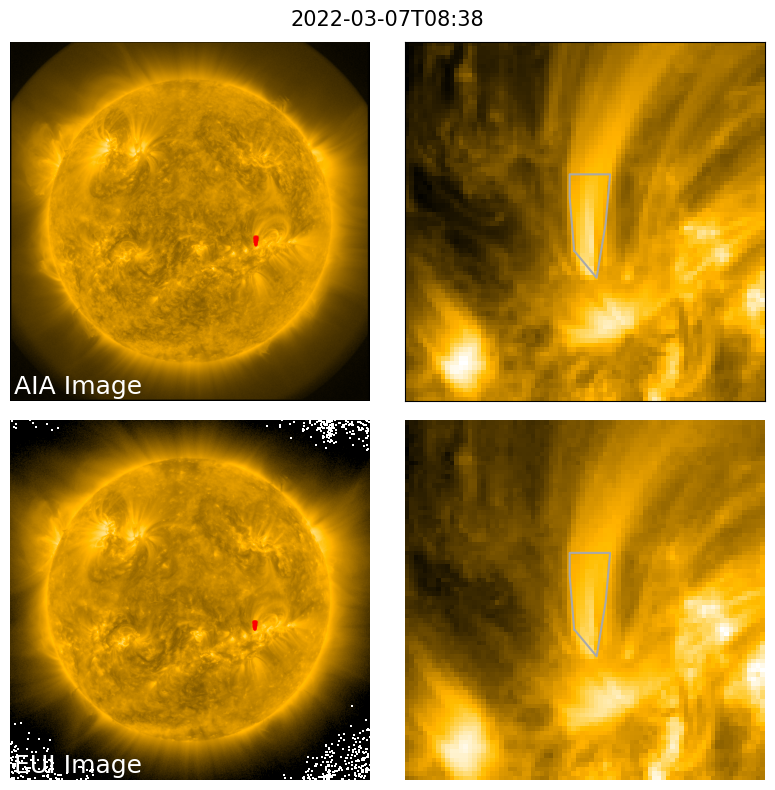

In [5]:
#DEM calculate_3 (Imaging)
plt.tight_layout()
plt.figure(figsize=(8, 8))

plt.subplot(2,2,1)
plt.imshow(np.log10(AIA_data), cmap = 'sdoaia171', origin='lower',vmin=0,vmax=4)
plt.text(10, 20, 'AIA Image', color='white', fontsize=18)
plt.scatter(ROI_x_pix,ROI_y_pix, s = .1,  c='r', marker = 'o', alpha = 0.5)
plt.axis('off')
plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2)
plt.imshow(np.log10(AIA_slice), cmap = 'sdoaia171', origin='lower')
plt.plot(vertex[:,0]-ref_aia_x+BOUNDARY,vertex[:,1]-ref_aia_y+BOUNDARY, c='darkgray')

plt.xticks([]), plt.yticks([])

plt.subplot(2,2,3)
plt.imshow(np.log10(EUI_image+1), cmap = 'sdoaia171', origin = 'lower',vmin=0,vmax=4)
plt.text(10, 20, 'EUI Image', color='white', fontsize=18)
plt.scatter(ROI_EUI_x,ROI_EUI_y, s = .1,  c='r', marker = 'o' , alpha = .5)
plt.axis('off')
plt.tight_layout()

plt.xticks([]), plt.yticks([])

plt.subplot(2,2,4)
plt.imshow(np.log10(EUI_slice+1), cmap = 'sdoaia171', origin='lower')
plt.plot(con_EUI_x-ref_eui_x+BOUNDARY,con_EUI_y-ref_eui_y+BOUNDARY, c='darkgray')##########################
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.tight_layout()


plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.suptitle('{}'.format(AIA_hdr['date-obs'][:16]), fontsize=15, y=0.98)# y 값으로 제목의 상대적 위치 조정
plt.tight_layout(pad=1)
os.makedirs(os.path.dirname(image_save_path+'{}'.format(date+'_ROI_plot_'+ROI_NUM)), exist_ok=True)
plt.savefig(image_save_path+'{}'.format(date+'_ROI_plot_'+ROI_NUM))
        
plt.show()

In [6]:
def get_dem(data, edata, tresp_logt,inst, y1= 0, y2= 1024, x1= 0, x2= 1024, nt = 21):
    
    temperatures=10**np.arange(4-0.05,8+0.15,0.1)
    # temperatures = 10**np.linspace(4,8, 41)
    # mlogt = min(temperatures)+1e-8+(max(temperatures)-min(temperatures))*np.arange(40)/(40-1.0)
    
    mlogt=([np.mean([(np.log10(temperatures[i])),np.log10((temperatures[i+1]))]) \
            for i in np.arange(0,len(temperatures)-1)])
    

    if inst == 'AIA':
        print('AIA_trmatrix')
        dem,edem,elogt,chisq,dn_reg=dn2dem(data[y1:y2,x1:x2,:],edata[y1:y2,x1:x2,:],
                                           AIA_trmatrix,tresp_logt,temperatures)
    elif inst == 'EUI':
        print('EUI_trmatrix')
        dem,edem,elogt,chisq,dn_reg=dn2dem(data[y1:y2,x1:x2,:],edata[y1:y2,x1:x2,:],
                                           EUI_trmatrix,tresp_logt,temperatures)
        
    # elif inst == 'EUI2':
    #     print('EUI_trmatrix')
    #     dem,edem,elogt,chisq,dn_reg=dn2dem(data[y1:y2,x1:x2,:],edata[y1:y2,x1:x2,:],
    #                                        EUI_trmatrix2,tresp_logt,temperatures)
    return dem,edem,elogt,chisq,dn_reg,mlogt


In [7]:
AIAs = DEM_SET(input_folder_AIA)
EUIs = DEM_SET(input_folder_EUI)

AIA_DN_data, AIA_edata = setting(AIAs, 'AIA')
EUI_DN_data, EUI_edata = setting(EUIs, 'EUI')


AIA_trin= np.load('/userhome/youn_j/DEM/HRI/Paper/resp_concat_AIA_rev1.npy')
# EUI_trin= np.load('/userhome/youn_j/DEM/HRI/Paper/resp_concat_AIA.npy')

EUI_trin= np.load('/userhome/youn_j/DEM/HRI/Paper/resp_concat_FSI_factor0.7_rev1.npy')
EUI_trin2 = np.load('/userhome/youn_j/DEM/HRI/Paper/resp_concat_FSI_factor0.7_rev1.npy')

tresp_logt = np.linspace(4,8,81) #V3
nt=len(tresp_logt) #V3: 81개
nf = 6


AIA_trmatrix=np.zeros((nt,nf)) #빈 array를 만들어 주자
EUI_trmatrix=np.zeros((nt,nf)) #빈 array를 만들어 주자
EUI_trmatrix2=np.zeros((nt,nf)) #빈 array를 만들어 주자

for i in range(6):
    # temperature bin 마다의 response ft. [94A, 131, ~~~, ]
    AIA_trmatrix[:,i]=AIA_trin[i]
    EUI_trmatrix[:,i]=EUI_trin[i]
    EUI_trmatrix2[:,i]=EUI_trin2[i]
    

AIA_dem,AIA_edem,AIA_elogt,AIA_chisq,AIA_dn_reg,AIA_mlogt = get_dem(AIA_DN_data, AIA_edata, tresp_logt,'AIA',
                                                                    y1 = np.uint(ref_aia_y - BOUNDARY),
                                                                    y2 = np.uint(ref_aia_y + BOUNDARY),
                                                                    x1 = np.uint(ref_aia_x - BOUNDARY),
                                                                    x2 = np.uint(ref_aia_x + BOUNDARY))
EUI_dem,EUI_edem,EUI_elogt,EUI_chisq,EUI_dn_reg,EUI_mlogt = get_dem(EUI_DN_data, EUI_edata, tresp_logt,'EUI',
                                                                    y1 = np.uint(ref_eui_y - BOUNDARY),
                                                                    y2 = np.uint(ref_eui_y + BOUNDARY),
                                                                    x1 = np.uint(ref_eui_x - BOUNDARY),
                                                                    x2 = np.uint(ref_eui_x + BOUNDARY))


# ================================================================

# AIA_g_dem=AIA_g_edem=AIA_g_elogt=AIA_g_chisq=AIA_g_dn_reg=AIA_g_mlogt = 0.

# if COMP_NUM == 3:
#     AIA_g_dem,AIA_g_edem,AIA_g_elogt,AIA_g_chisq,AIA_g_dn_reg,AIA_g_mlogt  = get_dem(EUI_data, EUI_edata, tresp_logt,'EUI2',
#                                                                     y1 = np.uint(ref_eui_y - BOUNDARY),
#                                                                     y2 = np.uint(ref_eui_y + BOUNDARY),
#                                                                     x1 = np.uint(ref_eui_x - BOUNDARY),
#                                                                     x2 = np.uint(ref_eui_x + BOUNDARY))

/userhome/youn_j/DEM/DEM_testsetV240610/AIA/20220307T0830/2022-03-07T083824_094.fits
/userhome/youn_j/DEM/DEM_testsetV240610/AIA/20220307T0830/2022-03-07T083824_131.fits
/userhome/youn_j/DEM/DEM_testsetV240610/AIA/20220307T0830/2022-03-07T083824_171.fits
/userhome/youn_j/DEM/DEM_testsetV240610/AIA/20220307T0830/2022-03-07T083824_193.fits
/userhome/youn_j/DEM/DEM_testsetV240610/AIA/20220307T0830/2022-03-07T083824_211.fits
/userhome/youn_j/DEM/DEM_testsetV240610/AIA/20220307T0830/2022-03-07T083824_335.fits
/userhome/youn_j/DEM/DEM_testsetV240610/EUI_Gen/20220307T0830/2022-03-07T0833_094_AI.fits
/userhome/youn_j/DEM/DEM_testsetV240610/EUI_Gen/20220307T0830/2022-03-07T0833_131_AI.fits
/userhome/youn_j/DEM/DEM_testsetV240610/EUI_Gen/20220307T0830/2022-03-07T0833_174.fits
/userhome/youn_j/DEM/DEM_testsetV240610/EUI_Gen/20220307T0830/2022-03-07T0833_193_AI.fits
/userhome/youn_j/DEM/DEM_testsetV240610/EUI_Gen/20220307T0830/2022-03-07T0833_211_AI.fits
/userhome/youn_j/DEM/DEM_testsetV240610/EUI

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64.0/64.0 [00:01<00:00, 38.9 x10^2 DEM/s]

EUI_trmatrix



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64.0/64.0 [00:01<00:00, 34.6 x10^2 DEM/s]


In [11]:
print(AIA_dem[0,0,:].shape == np.array(AIA_mlogt).shape)
# print()
print(AIA_mlogt)
print(np.array(AIA_mlogt).shape)
# print()
# print(tresp_logt)

True
[4.0, 4.1, 4.199999999999999, 4.299999999999999, 4.399999999999999, 4.499999999999998, 4.599999999999998, 4.6999999999999975, 4.799999999999997, 4.899999999999997, 4.9999999999999964, 5.099999999999996, 5.199999999999996, 5.299999999999995, 5.399999999999995, 5.499999999999995, 5.599999999999994, 5.699999999999994, 5.799999999999994, 5.899999999999993, 5.999999999999993, 6.0999999999999925, 6.199999999999992, 6.299999999999992, 6.3999999999999915, 6.499999999999991, 6.599999999999991, 6.69999999999999, 6.79999999999999, 6.89999999999999, 6.999999999999989, 7.099999999999989, 7.199999999999989, 7.299999999999988, 7.399999999999988, 7.499999999999988, 7.599999999999987, 7.699999999999987, 7.7999999999999865, 7.899999999999986, 7.999999999999986]
(41,)


In [12]:
import torch
import torch.nn as nn
# CUDA
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda:0")

In [13]:
selected_indices = np.arange(0, 80, 2)
rmatrix_selected = AIA_trmatrix[selected_indices, :]
dlogT = []

for i in range(len(AIA_mlogt)-1):
    dlogT.append(10**(AIA_mlogt[i+1])-10**(AIA_mlogt[i]))
# dlogT.append(8.0)

dlogT = np.array(dlogT)
print(dlogT.shape)

rmatrix_selected = torch.tensor(rmatrix_selected, dtype=torch.float32, device=device)
dem = torch.tensor(AIA_dem[:,:,:-1], dtype=torch.float32, device=device)
dlogT = torch.tensor(dlogT, dtype=torch.float32, device=device)





dem = dem.view(-1,40)* dlogT 


print(dem.shape)

dn_reg = torch.matmul(dem,rmatrix_selected)
dn_reg = dn_reg.view(80, 80, -1)
print(dn_reg.shape)  # 결과 형태 출력
print(dn_reg.device)  # 결과가 GPU에서 연산되었는지 확인


(40,)
torch.Size([6400, 40])
torch.Size([80, 80, 6])
cuda:0


In [14]:
# print(dem)
# print(dlogT)
# print(AIA_trmatrix)
# print(AIA_dem[:,:,:-1].shape)

print(AIA_edata[0,0,:])

[1.18824089 1.22666883 1.19783823 1.24591991 1.24591991 1.22666883]


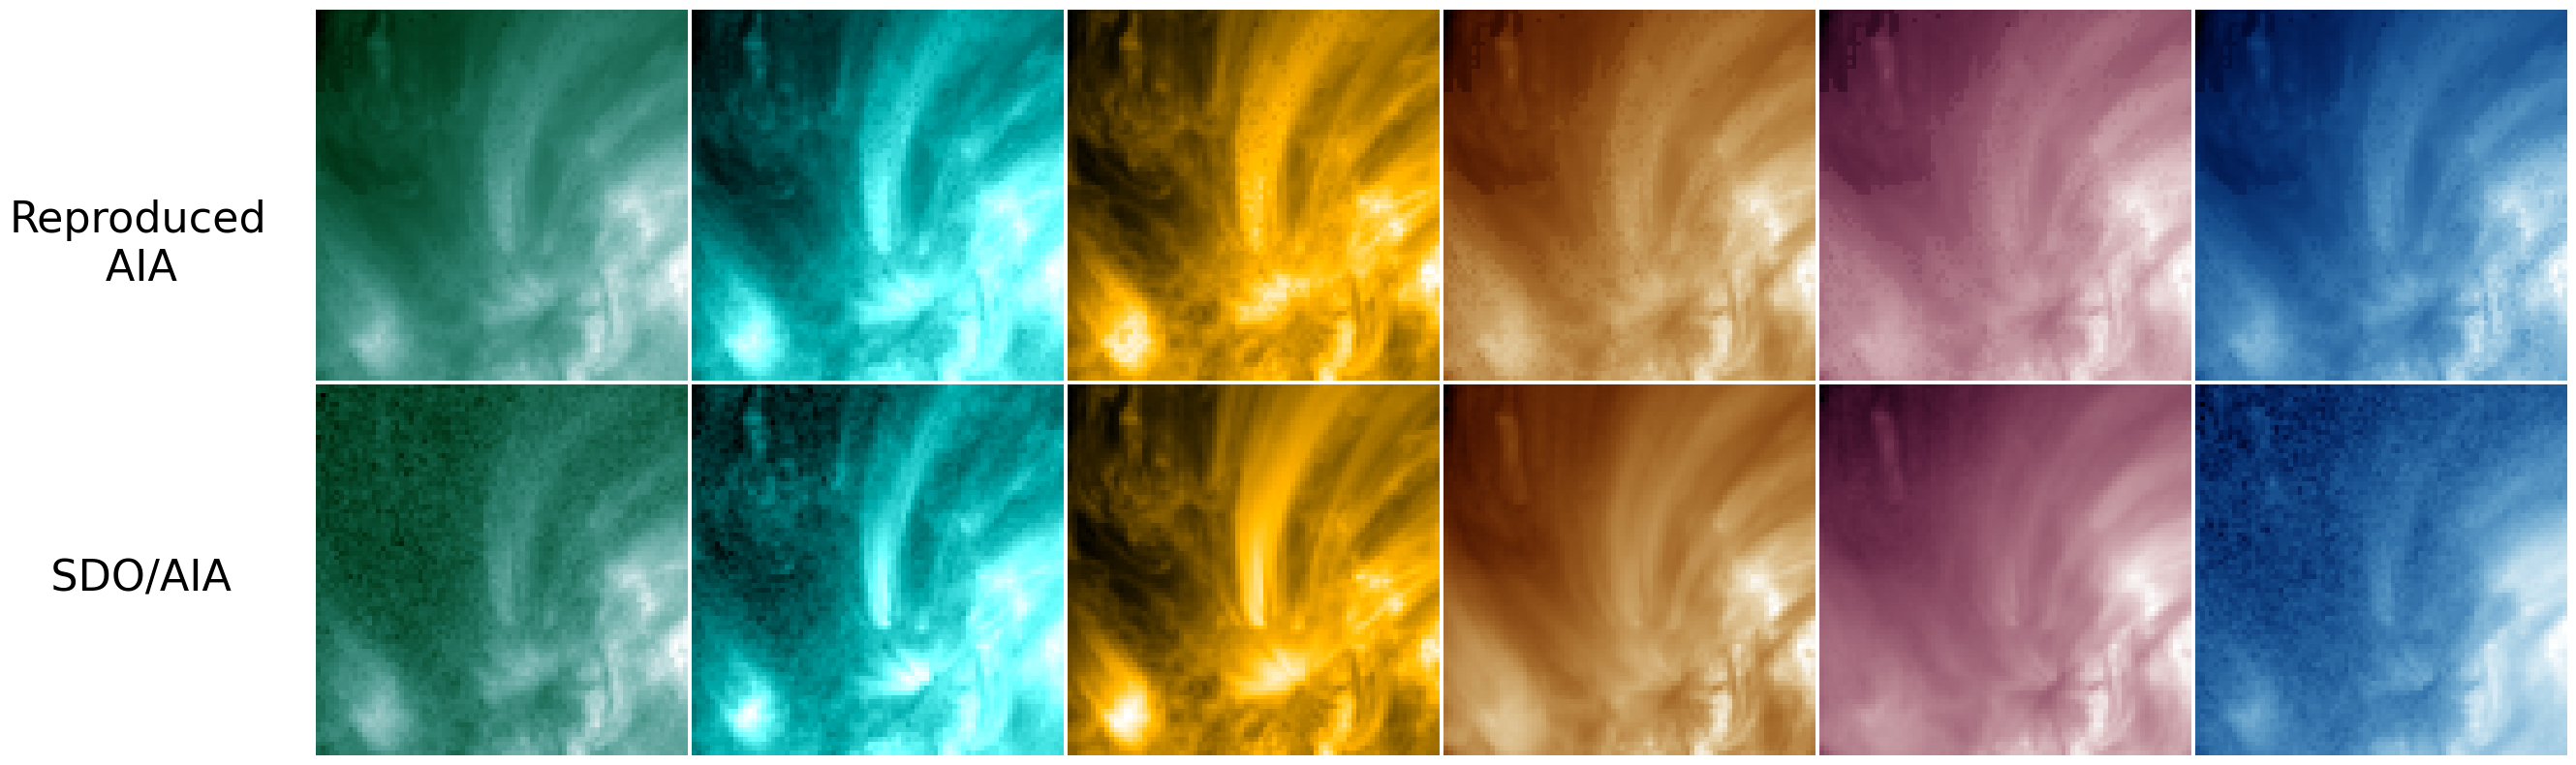

In [37]:
wavenum = ['94', '131', '171', '193', '211', '335']

fig, axes = plt.subplots(2, 6, figsize=(30, 10))

# 첫 번째 행
for i in range(6):
    axes[0, i].imshow(np.log2(dn_reg[:, :, i].cpu()), origin='lower', cmap=f'sdoaia{wavenum[i]}')#, vmin=0.05, vmax=13
    axes[0, i].axis('off')

# 두 번째 행
for i in range(6):
    axes[1, i].imshow(np.log2(AIA_DN_data[
        np.uint(ref_aia_y - BOUNDARY):np.uint(ref_aia_y + BOUNDARY),
        np.uint(ref_aia_x - BOUNDARY):np.uint(ref_aia_x + BOUNDARY),
        i]),
        cmap=f'sdoaia{wavenum[i]}', origin='lower') #, vmin=0.05, vmax=13
    axes[1, i].axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)

fig.text(0.02, 0.6, 'Reproduced\n       AIA', fontsize=32)
fig.text(0.02, 0.28, '   SDO/AIA', fontsize=32)

plt.show()

In [24]:
for i in range(6):
    print(np.median(dn_reg[:,:,i].cpu().numpy()))    
    print(np.median((AIA_DN_data[
        np.uint(ref_aia_y - BOUNDARY):np.uint(ref_aia_y + BOUNDARY),
        np.uint(ref_aia_x - BOUNDARY):np.uint(ref_aia_x + BOUNDARY),
        i])))
    print(np.median(dn_reg[:,:,i].cpu().numpy())-np.median((AIA_DN_data[
        np.uint(ref_aia_y - BOUNDARY):np.uint(ref_aia_y + BOUNDARY),
        np.uint(ref_aia_x - BOUNDARY):np.uint(ref_aia_x + BOUNDARY),
        i])))
    print('================')

1.3280193
1.0556055307388306
0.2724137306213379
5.8052673
5.95939040184021
-0.15412306785583496
253.8273
256.2036437988281
-2.3763427734375
243.29494
263.9933624267578
-20.69842529296875
62.858364
67.94181823730469
-5.083454132080078
2.1883965
2.753529191017151
-0.565132737159729


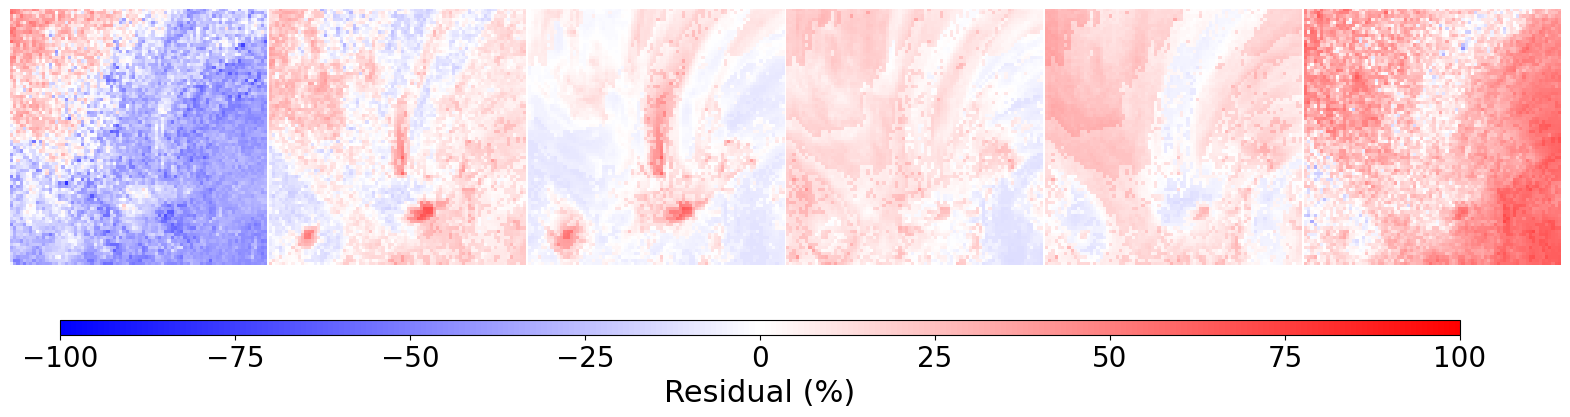

[0.0572565  0.15793382 0.93472446 0.95284671 0.77960075 1.24193578]


In [34]:
# residual = np.zeros((80,80,6))
# for i in range(6):
#     residual[:,:,i] = np.log10(dn_reg[:, :, i].cpu()) - np.log10(AIA_DN_data[
#             np.uint(ref_aia_y - BOUNDARY):np.uint(ref_aia_y + BOUNDARY),
#             np.uint(ref_aia_x - BOUNDARY):np.uint(ref_aia_x + BOUNDARY),
#             i])
# plt.figure(figsize=(200,25))

# for i in range(6):
#     plt.subplot(1,6,i+1)
#     plt.imshow(10**residual[:,:,i],cmap = 'bwr',origin='lower')
#     plt.axis('off')
# plt.subplots_adjust(wspace=0.01, hspace=0)
# plt.colorbar(orientation='horizontal')
AIA_crop = AIA_DN_data[
        np.uint(ref_aia_y - BOUNDARY):np.uint(ref_aia_y + BOUNDARY),
        np.uint(ref_aia_x - BOUNDARY):np.uint(ref_aia_x + BOUNDARY),
        :]
# Residual
residual = np.zeros((80, 80, 6))
chi2 = []

# Residual 계산
for i in range(6):
    residual[:, :, i] = (AIA_crop[:,:,i])-(dn_reg[:,:,i].cpu().numpy())

# Figure
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

im = None  # colorbar 연동을 위한 변수
for i in range(6):
    im = axes[i].imshow(100*(residual[:, :, i]/AIA_crop[:,:,i]), cmap='bwr', origin='lower', vmin=-100, vmax=100)
    axes[i].axis('off')

    
    chi2.append(np.sum((residual[:, :, i] / AIA_edata[
        np.uint(ref_aia_y - BOUNDARY):np.uint(ref_aia_y + BOUNDARY),
        np.uint(ref_aia_x - BOUNDARY):np.uint(ref_aia_x + BOUNDARY),
        i]) ** 2)/(6400-40))    # N-k = pixel-Temp.bin H&K eq(7)
    
chi2 = np.array(chi2)
# 서브플롯 간격 조정
plt.subplots_adjust(wspace=0.01, hspace=0)

# 통합된 Colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=20) 
cbar.set_label("Residual (%)", fontsize=22) 
cbar.ax.xaxis.get_offset_text().set_fontsize(20)
plt.show()

print(chi2)

In [33]:
chi2

array([0.0572565 , 0.15793382, 0.93472446, 0.95284671, 0.77960075,
       1.24193578])

In [31]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("CuDNN Version:", torch.backends.cudnn.version())
print("Device Count:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU Device Name:", torch.cuda.get_device_name(0))

PyTorch Version: 2.5.1
CUDA Available: False
CUDA Version: None
CuDNN Version: None
Device Count: 0


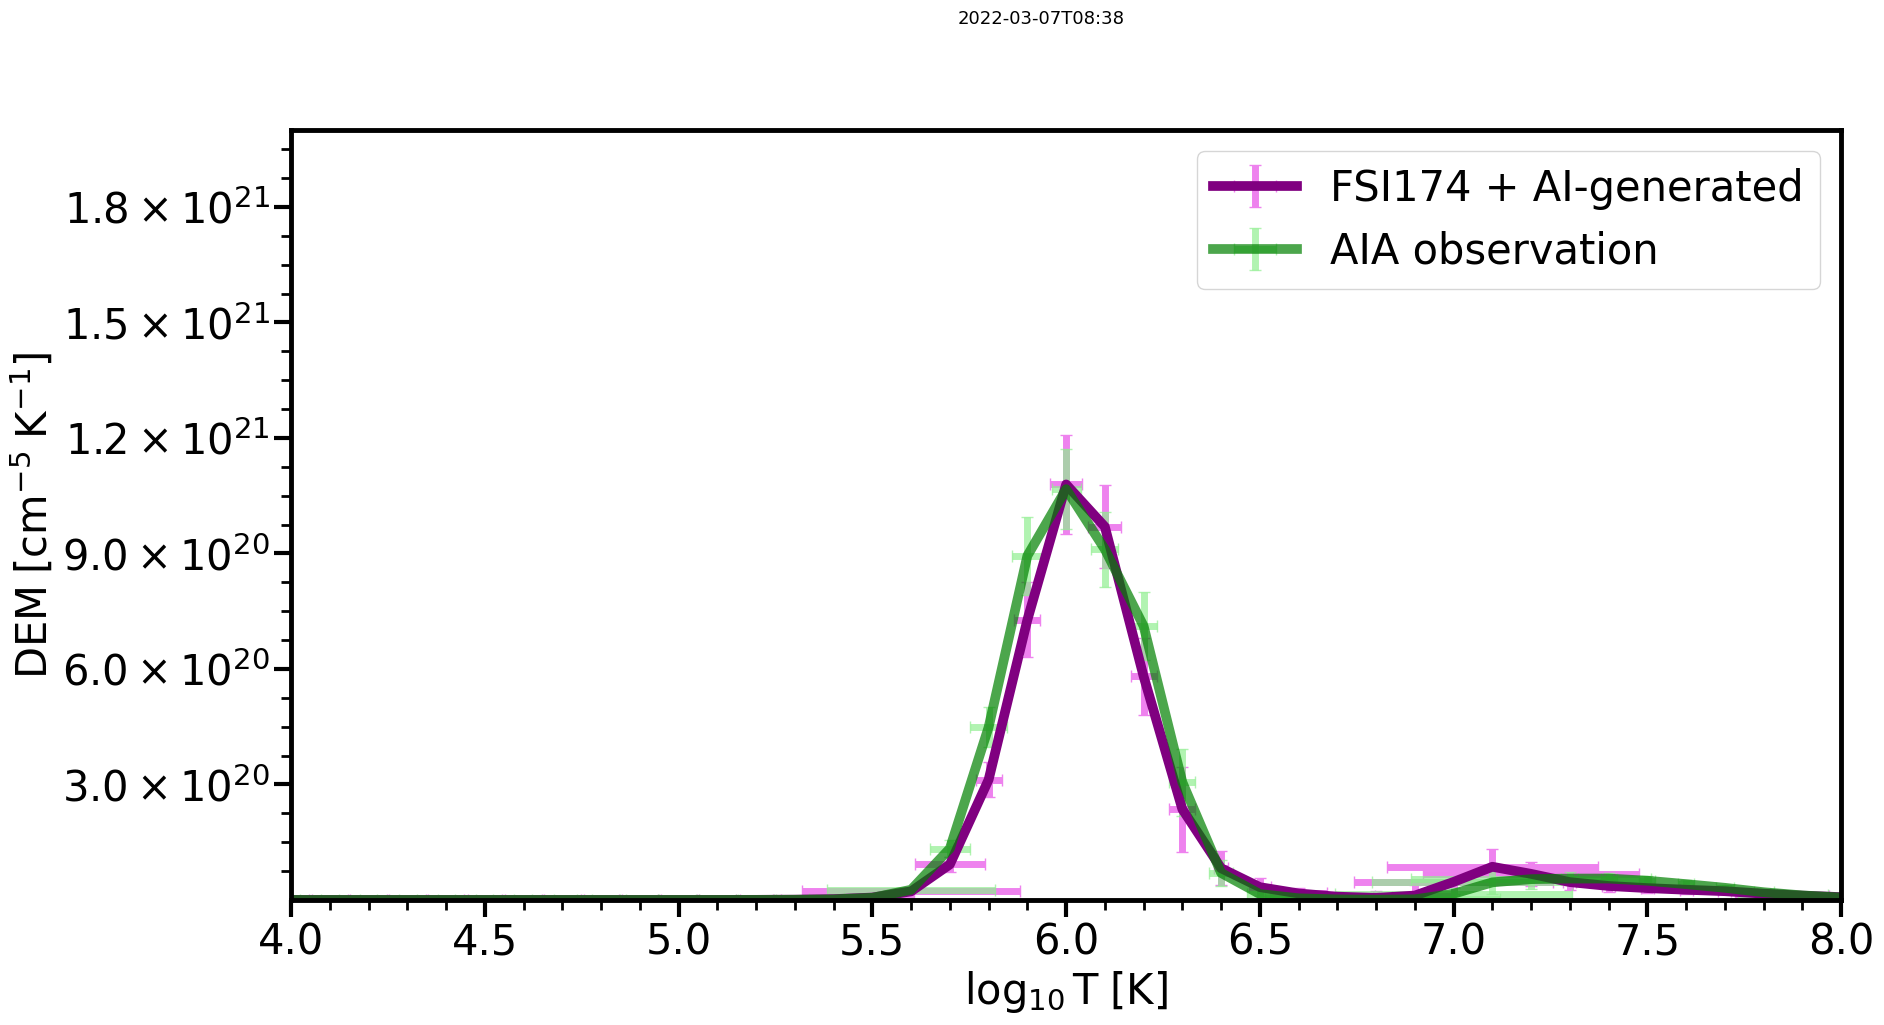

In [20]:

# def exp_formatter(x, pos):
#     if x == 0:
#         return '0'
#     exponent = int(np.log10(x))
# #     exponent = 21
#     coeff = x / 10**exponent
#     return r'${:.1f} \times 10^{{{:d}}}$'.format(coeff, exponent)

# AIA_pos = UniqueArray(ROI_x_pix-ref_aia_x+BOUNDARY ,ROI_y_pix-ref_aia_y+BOUNDARY)
# EUI_pos = UniqueArray(ROI_EUI_x-ref_eui_x+BOUNDARY ,ROI_EUI_y-ref_eui_y+BOUNDARY)

# Plot = 'linear' #log

# def plot_dem_N(ax,AIA_dem, AIA_elogt, AIA_edem, AIA_mlogt,
#              EUI_dem, EUI_elogt, EUI_edem, EUI_mlogt,
#              AIA_g_dem = None, AIA_g_elogt= None, AIA_g_edem= None, AIA_g_mlogt= None):
# #     print(np.max(AIA_dem))
#     if Plot == 'log':
#         yr = [1e16, np.max(EUI_dem[AIA_pos[0],AIA_pos[1]])*5]
#     if Plot == 'linear':
#         # yr = [1e16, (np.max(AIA_dem[AIA_pos[0],AIA_pos[1]]) + np.max(EUI_dem[EUI_pos[0],EUI_pos[1]]))/2.5]
#         yr = [1e16,2e21]


#     xr = [4., 8.]
    
# #     fig, ax = plt.subplots(figsize=(8, 3))
    
    
#     AIA_dem_avg = []
#     EUI_dem_avg = []
#     AIA_g_dem_avg = []
    
    
#     AIA_elogt_avg = []
#     EUI_elogt_avg = []
#     AIA_g_elogt_avg  = []
    
    
#     AIA_edem_avg = []
#     EUI_edem_avg = []
#     AIA_g_edem_avg = []
    
#     #ROI_EUI_x-ref_eui_x+50 ,ROI_EUI_y-ref_eui_y+50 이부분 좌표로 따야 함
    
    
    
#     for i in range(len((AIA_dem[BOUNDARY, BOUNDARY,:]))):
#         _tmp_aia_dem = np.average(AIA_dem[AIA_pos[0],AIA_pos[1],i])
#         _tmp_eui_dem = np.average(EUI_dem[EUI_pos[0],EUI_pos[1],i])
        
#         _tmp_aia_elogt = np.average(AIA_elogt[AIA_pos[0],AIA_pos[1],i])
#         _tmp_eui_elogt = np.average(EUI_elogt[EUI_pos[0],EUI_pos[1],i])
        
#         _tmp_aia_edem = np.average(AIA_edem[AIA_pos[0],AIA_pos[1],i])
#         _tmp_eui_edem = np.average(EUI_edem[EUI_pos[0],EUI_pos[1],i])
        
    
#         AIA_dem_avg.append(_tmp_aia_dem) 
#         EUI_dem_avg.append(_tmp_eui_dem) 

#         AIA_elogt_avg.append(_tmp_aia_elogt) 
#         EUI_elogt_avg.append(_tmp_eui_elogt) 

#         AIA_edem_avg.append(_tmp_aia_edem) 
#         EUI_edem_avg.append(_tmp_eui_edem)
        
        
        
#         if COMP_NUM == 3:
#             _tmp_aia_g_dem = np.average(AIA_g_dem[AIA_pos[0],AIA_pos[1],i])
#             _tmp_aia_g_elogt = np.average(AIA_g_elogt[AIA_pos[0],AIA_pos[1],i])
#             _tmp_aia_g_edem = np.average(AIA_g_edem[AIA_pos[0],AIA_pos[1],i])
#             AIA_g_dem_avg.append(_tmp_aia_g_dem) 
#             AIA_g_elogt_avg.append(_tmp_aia_g_elogt) 
#             AIA_g_edem_avg.append(_tmp_aia_g_edem)
            
            
#     # EUI_gen 그래프
#     ax.errorbar(EUI_mlogt, EUI_dem_avg, xerr=EUI_elogt_avg, yerr=EUI_edem_avg, fmt='-',\
#                  color='purple',ecolor='violet', elinewidth=5, capsize=4, alpha = 1, label='FSI174 + AI-generated', linewidth =7)
            
# #     AIA 그래프
#     ax.errorbar(AIA_mlogt, AIA_dem_avg , xerr=AIA_elogt_avg, yerr=AIA_edem_avg, fmt='-',\
#                 color='green',ecolor='lightgreen', elinewidth=5, capsize=4, alpha = 0.7, label='AIA observation', linewidth =7)
    

#     if COMP_NUM == 3:
#         ax.errorbar(AIA_g_mlogt, AIA_g_dem_avg , xerr=AIA_g_elogt_avg, yerr=AIA_g_edem_avg, fmt='-g',\
#                              ecolor='lightgreen', elinewidth=4, capsize=5, label='AIA_GEN')
    
#     for axis in ['top','bottom','left','right']:
#         ax.spines[axis].set_linewidth(3.5)
        
    
#     ax.set_xlabel('$\mathrm{\log_{10}T\;[K]}$',fontsize=30)
#     ax.set_ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$',fontsize=30)
    
#     ax.xaxis.get_offset_text().set_fontsize(30)
#     ax.yaxis.get_offset_text().set_fontsize(30)

    
#     ax.set_ylim(yr)
#     ax.set_xlim(xr)
    
#     if Plot == 'linear':
#         ax.set_yscale('linear')
#         ax.yaxis.set_major_formatter(FuncFormatter(exp_formatter)) 
#         ax.yaxis.set_major_locator(ticker.MultipleLocator(3e20))
#         ax.xaxis.set_minor_locator(AutoMinorLocator())
#         ax.yaxis.set_minor_locator(AutoMinorLocator())
#         ax.tick_params(axis='both', which='minor', length=7, width=2)
#         ax.tick_params(axis='both', which='major', length=12, width=3, labelsize=30)
        
        
#     if Plot == 'log':
#         ax.set_yscale('log')
    
#     ax.legend(fontsize=30)
    

#     plt.suptitle('{}'.format(AIA_hdr['date-obs'][:16]), fontsize=13, y=1)# y 값으로 제목의 상대적 위치 조정
# #     plt.savefig('/userhome/youn_j/DEM/Result/Result_240325/{}'.format(date+'_'+Plot+'_plot_'+ROI_NUM))

# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot()
# plot_dem_N(ax, AIA_dem, AIA_elogt, AIA_edem, AIA_mlogt, EUI_dem, EUI_elogt, EUI_edem, EUI_mlogt)

2025-03-12 19:52:51 - sunpy - INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144)


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144) [sunpy.coordinates.ephemeris]

./test/20220307T0830_Full_SET_fig4_linear
fig4


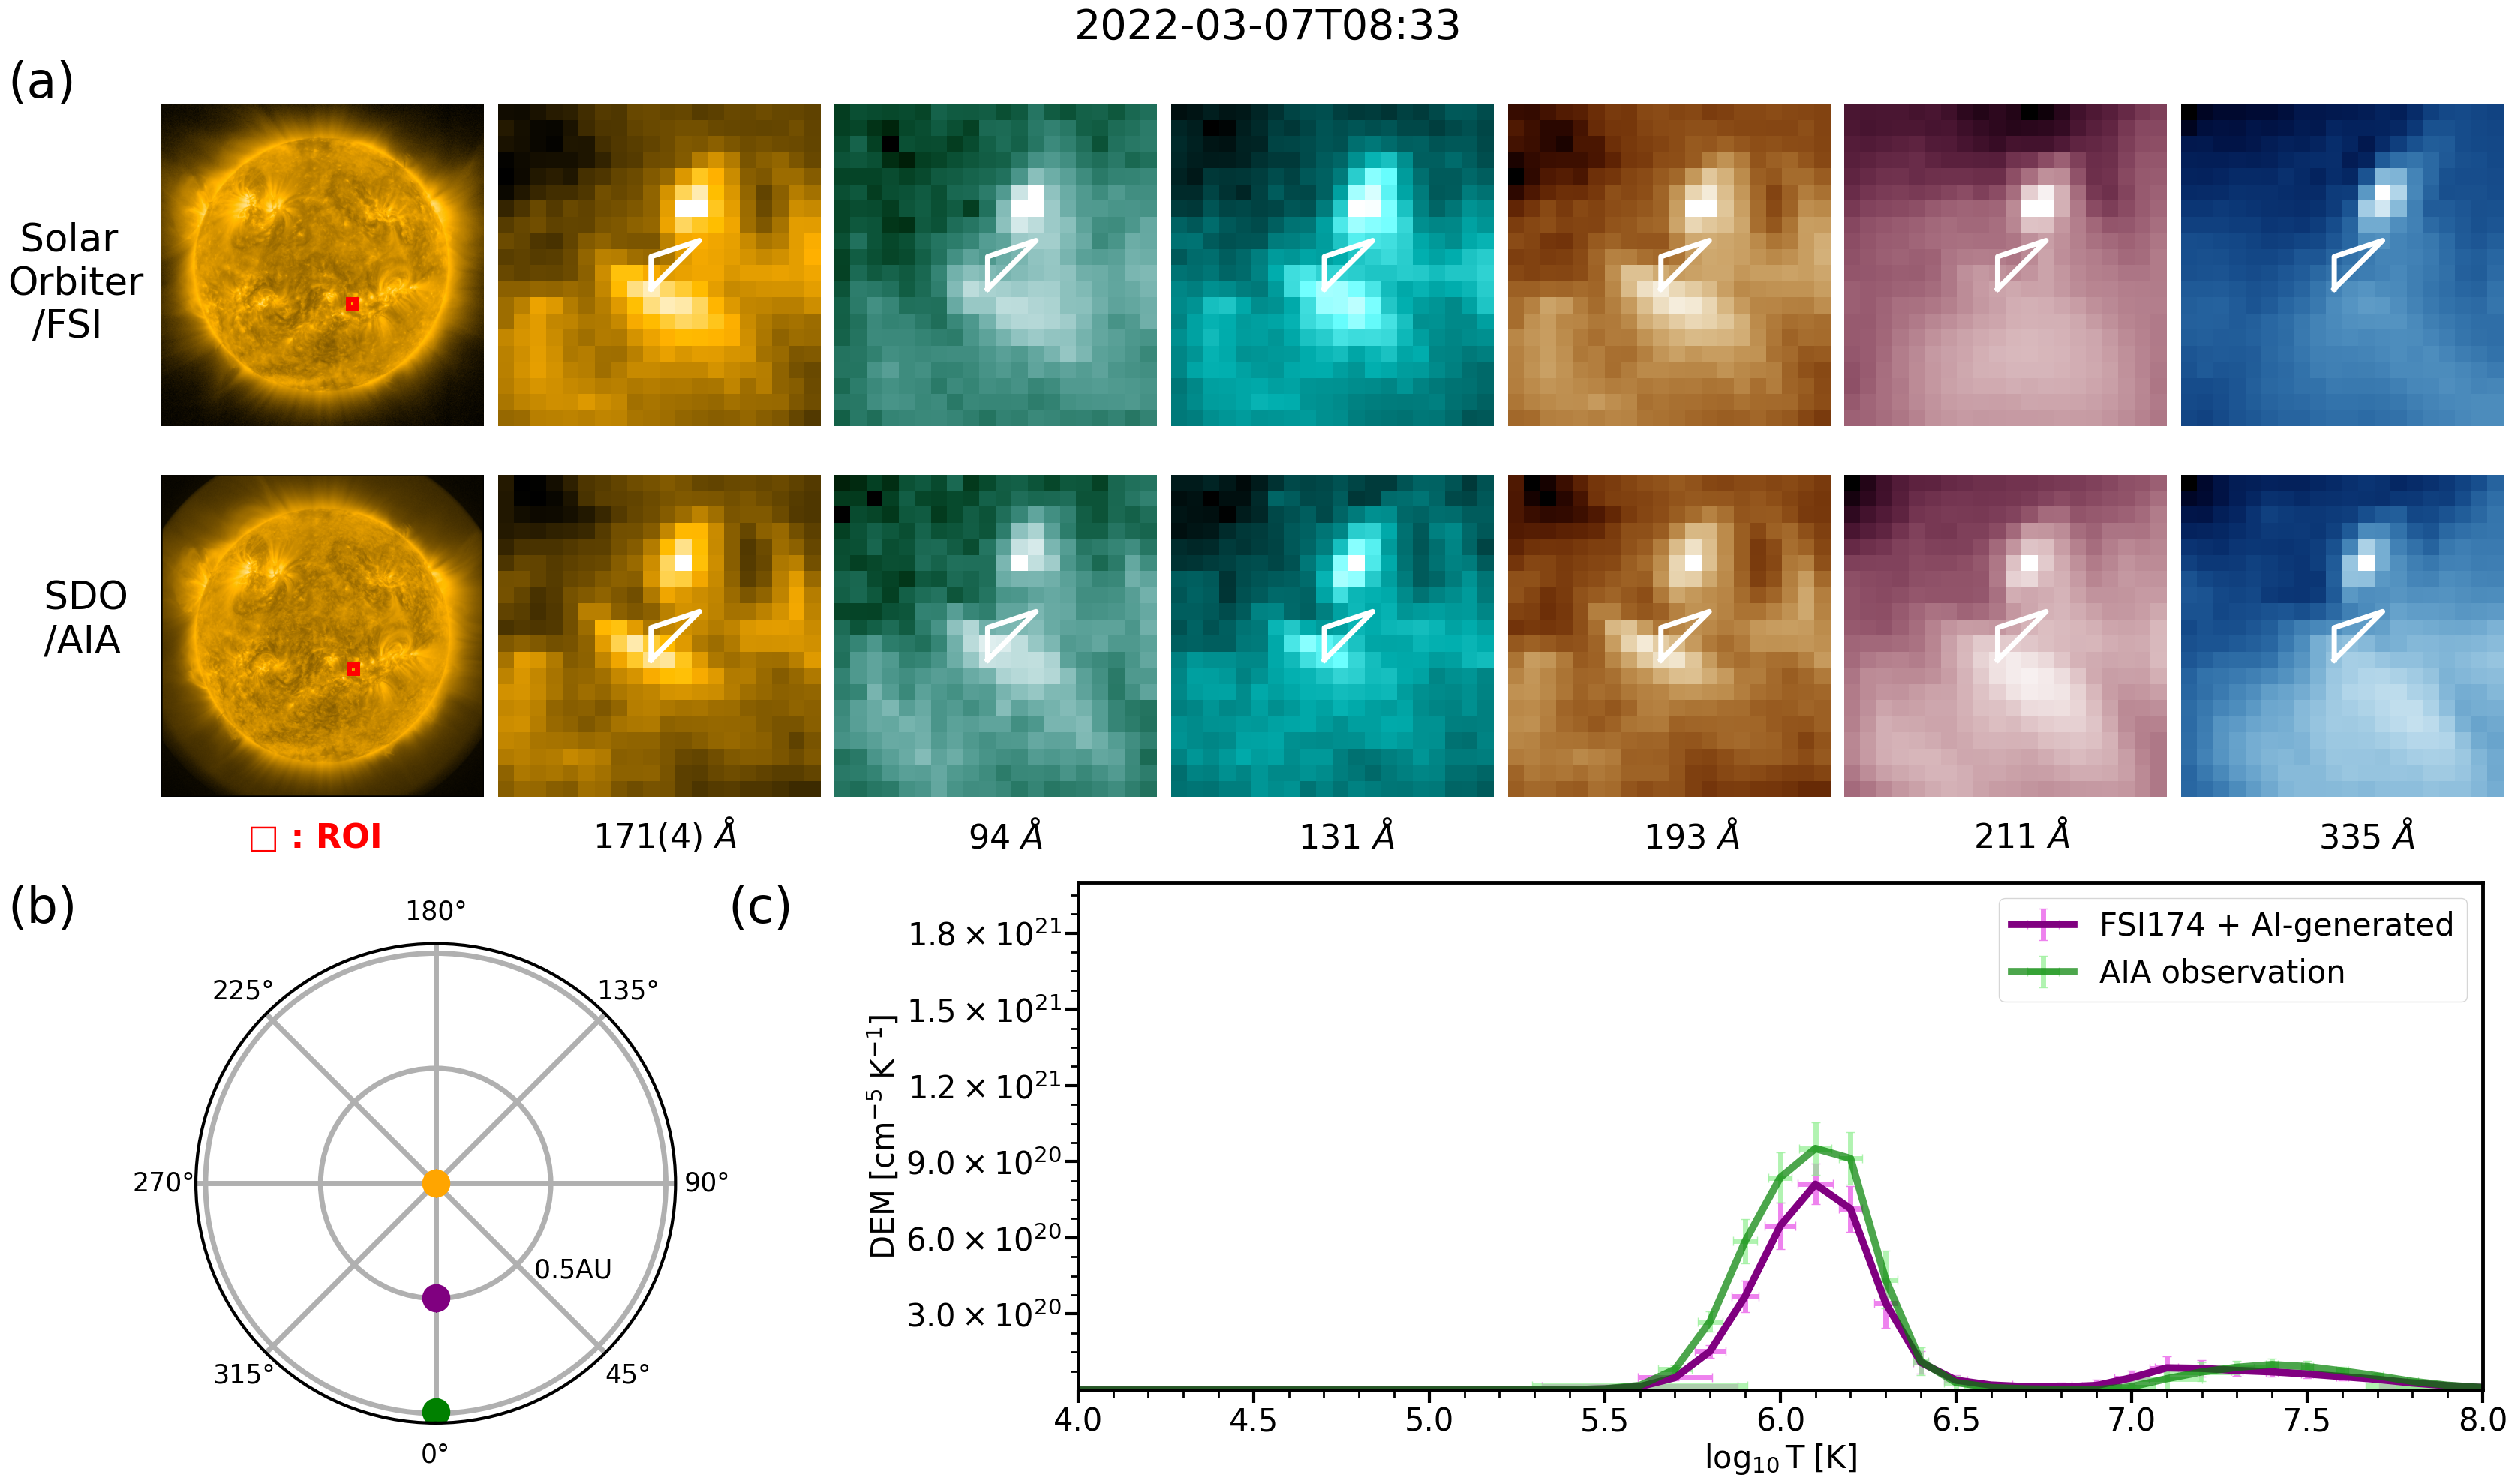

In [146]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt

# # plt.rc('font', size=30)
# from matplotlib.gridspec import GridSpec
# import astropy.units as u
# from sunpy.coordinates import get_body_heliographic_stonyhurst, get_horizons_coord
# from sunpy.time import parse_time
# import numpy as np
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.patches import Rectangle
# Plot = 'linear' #log 

# def custom_yticks(x, pos):
#     if x == int(x):
#         return None
#     else:
#         return "     "+str(round(x, 2))+"AU"

# # Set up the figure and grid
# fig = plt.figure(figsize=(40,20))



# gs = GridSpec(4, 7, figure=fig, 
#               height_ratios=[2, 2, 2, 2],  # 조절하여 각 행의 상대적 높이를 변경합니다.
#               width_ratios=[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7],  # 조절하여 각 열의 상대적 너비를 변경합니다.
#               hspace=0.1, wspace=0.1)  # 필요에 따라 전체적인 여백을 조정합니다.

# #======================================plot1===============================================

# ax1 = fig.add_subplot(gs[2:, 0:2], projection='polar')

# # Define the coordinate conversion function
# def coord_to_polar(coord):
#     return coord.lon.to_value('rad'), coord.radius.to_value('AU')

# # Set the date for the plot

# plot_date = parse_time(EUIs[2].meta['date-obs'][:19])

# # Get coordinates
# psp = get_horizons_coord('Solar Orbiter', {'start': plot_date, 'stop': plot_date + 1 * u.day, 'step': '2d'})
# earth = get_body_heliographic_stonyhurst('Earth', plot_date)


# for label in ax1.get_yticklabels():
#     label.set_fontsize(20)

# ax1.plot(0, 0, 'o', label='Sun', color='orange', markersize=12, markeredgewidth=15)
# ax1.plot(*coord_to_polar(earth), 'o', markersize=12, label='Earth (SDO)', color='Green',markeredgewidth=15)
# ax1.plot(*coord_to_polar(psp), 'o', markersize=12, label='Solar Orbiter', color='Purple',markeredgewidth=15)
# ax1.grid(True, linewidth=5) 
# for spine in ax1.spines.values():
#     spine.set_linewidth(3.0)
    
# # Plot the polar data
# ax1.set_theta_zero_location('S')
# ax1.set_rlabel_position(30)
# formatter = FuncFormatter(custom_yticks)
# # ax1.set_yticks([np.round(float(coord_to_polar(psp)[1]),2), int(1)])
# ax1.yaxis.set_major_formatter(formatter)
# ax1.set_yticks([np.round(float(coord_to_polar(psp)[1]),2), int(1)]) 
# ax1.tick_params(axis='both', which='major', labelsize=25)
    
# pos_ax1 = ax1.get_position()
# new_pos_ax1 = [pos_ax1.x0, pos_ax1.y0*0.33 , pos_ax1.width * 0.90, pos_ax1.height * 0.85] # width를 줄여서 padding 효과를 냅니다.
# ax1.set_position(new_pos_ax1)

# ax1.tick_params(axis='both', which='major', pad=20, labelsize=25)

# # ax1.set_title('Stonyhurst heliographic coordinates \n' + str(plot_date)[:13], va='bottom')

# #==========================================plot2===========================================

# ax2 = fig.add_subplot(gs[2:, 2:])
# if COMP_NUM == 2:
#     plot_dem_N(ax2, AIA_dem, AIA_elogt, AIA_edem, AIA_mlogt, EUI_dem, EUI_elogt, EUI_edem, EUI_mlogt)
    
# if COMP_NUM == 3:
#     plot_dem_N(ax2,AIA_dem, AIA_elogt, AIA_edem, AIA_mlogt,
#              EUI_dem, EUI_elogt, EUI_edem, EUI_mlogt,
#              AIA_g_dem, AIA_g_elogt, AIA_g_edem, AIA_g_mlogt)

# pos_ax2 = ax2.get_position()
# new_pos_ax2 = [pos_ax2.x0*1.25, pos_ax2.y0 *0.53 , pos_ax2.width*0.85, pos_ax2.height* 0.9]  # width를 줄여서 padding 효과를 냅니다.
# ax2.set_position(new_pos_ax2)    


# #==========================================plot3===========================================
    
# ax3 = fig.add_subplot(gs[0, 0])
# ax3.imshow(np.log10(EUI_image), cmap = 'sdoaia171', origin='lower',vmin=0,vmax=4)
# rect = Rectangle((np.median(ROI_EUI_x)-BOUNDARY, np.median(ROI_EUI_y)-BOUNDARY),
#                  BOUNDARY*2.5, BOUNDARY*2.5, linewidth=5, edgecolor='r', facecolor='none')
# ax3.add_patch(rect)
# ax3.axis('off')

# # pos_ax3 = ax3.get_position()
# # new_pos_ax3 = [pos_ax3.x0, pos_ax3.y0*0.95, pos_ax3.width*1.2, pos_ax3.height*1.2]  # width를 줄여서 padding 효과를 냅니다.
# # ax3.set_position(new_pos_ax3)
# #==========================================plot4===========================================

# ax4 = fig.add_subplot(gs[1, 0])
# ax4.imshow(np.log10(AIA_data), cmap = 'sdoaia171', origin='lower',vmin=0,vmax=4)
# # ax3.scatter(ROI_x_pix,ROI_y_pix, s = 10,  c='r', marker = 'o', alpha = 0.5)
# rect = Rectangle((np.median(ROI_x_pix)-BOUNDARY, np.median(ROI_y_pix)-BOUNDARY),
#                  BOUNDARY*2.5, BOUNDARY*2.5, linewidth=5, edgecolor='r', facecolor='none')
# ax4.add_patch(rect)
# ax4.axis('off')

# #==========================================plot 5,6===========================================

# ax5 = fig.add_subplot(gs[0,1])
# plt.imshow(np.log10(EUI_slice), cmap = 'sdoaia171', origin='lower')
# plt.plot(con_EUI_x-ref_eui_x+BOUNDARY,con_EUI_y-ref_eui_y+BOUNDARY, c='white',linewidth =5)##########################
# plt.axis('off')
# plt.xticks([]), plt.yticks([])


# ax6 = fig.add_subplot(gs[1,1])
# plt.imshow(np.log10(AIA_slice), cmap = 'sdoaia171', origin='lower')
# plt.plot(vertex[:, 0] - ref_aia_x + BOUNDARY, vertex[:, 1] - ref_aia_y + BOUNDARY, c='white',linewidth =5)
# plt.axis('off')
# plt.xticks([]), plt.yticks([])

# subplots_ROI1 = [ax3, ax5]
# for ax in subplots_ROI1:
#     pos_ax = ax.get_position()
#     new_pos_ax35 = [pos_ax.x0, pos_ax.y0, pos_ax.width*1.2, pos_ax.height*1.2]  # width를 줄여서 padding 효과를 냅니다.
#     ax.set_position(new_pos_ax35)
    
    
# subplots_ROI2 = [ax4, ax6]
# for ax in subplots_ROI2:
#     pos_ax = ax.get_position()
#     new_pos_ax46 = [pos_ax.x0, pos_ax.y0*0.9, pos_ax.width*1.2, pos_ax.height*1.2]  # width를 줄여서 padding 효과를 냅니다.
#     ax.set_position(new_pos_ax46) 
    
    
# wavenum = ['94', '131', '193', '211', '335']
# ax7 = fig.add_subplot(gs[0, 2])
# ax8 = fig.add_subplot(gs[0, 3])
# ax9 = fig.add_subplot(gs[0, 4])
# ax10 = fig.add_subplot(gs[0, 5])
# ax11 = fig.add_subplot(gs[0, 6])
# subplots_EUI = [ax7, ax8, ax9, ax10, ax11]
# for eui_data, wave, ax in zip(EUIs, wavenum, subplots_EUI):
#     ax.imshow(np.log10(eui_data.data[np.uint(ref_eui_y - BOUNDARY):np.uint(ref_eui_y +BOUNDARY),
#                       np.uint(ref_eui_x-BOUNDARY):np.uint(ref_eui_x+ BOUNDARY)]), cmap = 'sdoaia{}'.format(wave), origin='lower')
#     ax.plot(con_EUI_x-ref_eui_x+BOUNDARY,con_EUI_y-ref_eui_y+BOUNDARY, c='white',linewidth =5)
#     ax.axis('off')

#     pos_ax = ax.get_position()
#     new_pos_ax_a = [pos_ax.x0, pos_ax.y0, pos_ax.width*1.2, pos_ax.height*1.2]  # width를 줄여서 padding 효과를 냅니다.
#     ax.set_position(new_pos_ax_a)    
        
# ax12 = fig.add_subplot(gs[1, 2])
# ax13 = fig.add_subplot(gs[1, 3])
# ax14 = fig.add_subplot(gs[1, 4])
# ax15 = fig.add_subplot(gs[1, 5])
# ax16 = fig.add_subplot(gs[1, 6],)
# subplots_AIA = [ax12, ax13, ax14, ax15, ax16]
# print()
# for aia_data, wave, ax in zip(AIAs, wavenum, subplots_AIA):
#     ax.imshow(np.log10(aia_data.data[np.uint(ref_aia_y - BOUNDARY):np.uint(ref_aia_y +BOUNDARY),
#                       np.uint(ref_aia_x-BOUNDARY):np.uint(ref_aia_x+ BOUNDARY)]),
#               cmap='sdoaia{}'.format(wave), origin='lower')
#     ax.plot(vertex[:, 0] - ref_aia_x + BOUNDARY, vertex[:, 1] - ref_aia_y + BOUNDARY, c='white',linewidth =5)
#     ax.axis('off')
    
#     pos_ax = ax.get_position()
#     new_pos_ax_e = [pos_ax.x0, pos_ax.y0*0.9, pos_ax.width*1.2, pos_ax.height*1.2]  # width를 줄여서 padding 효과를 냅니다.
#     ax.set_position(new_pos_ax_e)   
    
# # Set title for the figure
# # fig.suptitle(str(plot_date)[:13], fontsize=40)
# fig.suptitle(str(plot_date)[:16], fontsize=40, y=0.98) 
# # plt.tight_layout(pad=0.1)

# # Put numbers in each subplot
# # for i, ax in enumerate([ax12,ax13,ax14,ax15,ax16], start=12):
# #     ax.text(0.5, 0.5, str(i), fontsize=18, ha='center')

# # Adjust subplots
# plt.tight_layout()
# ft = 32
# fig.text(0.088, 0.55, ' SDO \n /AIA',fontsize=ft+5 )
# fig.text(0.080, 0.76, ' Solar\nOrbiter\n  /FSI ',fontsize=ft+5 )
# fig.text(0.16, 0.42, '\u25A1 : ROI',fontsize=ft, c='red',fontweight='bold' )
# fig.text(0.275, 0.42, r'171(4) $\AA$',fontsize=ft );fig.text(0.40, 0.42, r'94 $\AA$',fontsize=ft )
# fig.text(0.51, 0.42, r'131 $\AA$',fontsize=ft );fig.text(0.625, 0.42, r'193 $\AA$',fontsize=ft )
# fig.text(0.735, 0.42, r'211 $\AA$',fontsize=ft );fig.text(0.85, 0.42, r'335 $\AA$',fontsize=ft )


# fig.text(0.08, 0.92, '(a)',fontsize=ft+15)
# fig.text(0.08, 0.37, '(b)',fontsize=ft+15)
# fig.text(0.32, 0.37, '(c)',fontsize=ft+15)


# # plt.show()
# plt.savefig(image_save_path+'{}'.format(date+'_Full_SET_'+ROI_NUM+'_'+Plot))
# print(image_save_path+'{}'.format(date+'_Full_SET_'+ROI_NUM+'_'+Plot))
# print(ROI_NUM)